# Question 2

## Problem 3

In [1]:
import numpy as np
import time
import random
import matplotlib.pyplot as plt

In [2]:
N = 100
l = L = 1000
S = 217575
vmin = (0.5 + 0.02*S%21)
vmax = (3 + 0.2*S%11)
Ts =  86400

#### Assumptions 
Apply the same configurations as done in the book in example 6.5. Meaning that we use the stochastic recurrence.

In [3]:
def simulate_waypoint():

    x,y = random.randint(0,l+1), random.randint(0,L+1)
    v0 = random.uniform(vmin, vmax)

    m_init = np.array([x,y])
    v_init = v0
    t = 0
    
    M = [m_init]
    V = [v_init]
    T = [t]
    
    while(t < Ts):

        x,y = random.randint(0,l+1), random.randint(0,L+1)
        m = np.array([x,y])

        t = T[-1] + np.linalg.norm(m-M[-1])/V[-1]

        v = random.uniform(vmin, vmax)
        
        M.append(m)
        V.append(v)
        T.append(t)
 
    return np.array(M), np.array(V), np.array(T)

Retrieve all positions, times, and velocities of all users:

In [4]:
start = time.time()
M_users = []
V_users = []
T_users = []
for i in range(N):
    M, V, T = simulate_waypoint()
    M_users.append(M)
    V_users.append(V)
    T_users.append(T)
end = time.time()
print('Our program takes {:.2f} seconds to generate 1 day of data for N={} users.'.format(end-start, N))

Our program takes 2.18 seconds to generate 1 day of data for N=100 users.


In [5]:
len_waypoints = [len(waypoints) for waypoints in M_users]
print('Mean number of waypoints: {}.'.format(np.mean(len_waypoints)))
print('Minimum number of waypoints: {}.'.format(np.min(len_waypoints)))
print('Maximum number of waypoints: {}.'.format(np.max(len_waypoints)))

Mean number of waypoints: 1388.58.
Minimum number of waypoints: 1335.
Maximum number of waypoints: 1436.


Corresponding boxplot:

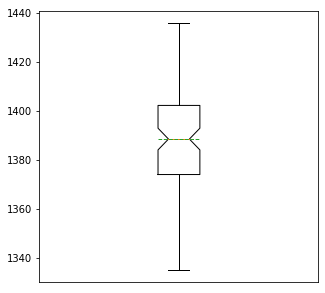

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.boxplot(len_waypoints, notch=True, showmeans=True, meanline=True)
ax.get_xaxis().set_visible(False)
plt.savefig('q2_boxplot')

Course for 1 and 8 users:

In [7]:
def plot_course(num_users, threshold=None):

    for i in range(num_users):
        
        pos_i = M_users[i]
        if threshold is not None:
            num_waypoints = threshold
        else:
            num_waypoints = len(pos_i)
        color = num_waypoints*['white']
        color[0] = 'black'
        x,y = pos_i[:num_waypoints, 0], pos_i[:num_waypoints, 1]
        plt.scatter(x,y, c=color, marker='.', alpha=0.5)
        plt.plot(x, y, linewidth=0.5)
        
    plt.savefig('q2_'+str(num_users)+'_users_'+str(num_waypoints)+'_waypoints')
    plt.show()

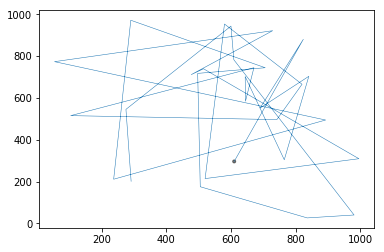

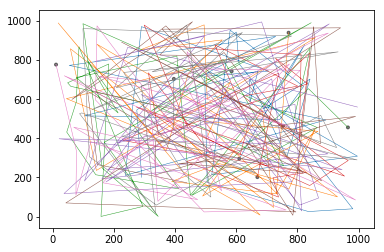

In [8]:
plot_course(1, 30)
plot_course(8, 30)

# Question 3

## Event Average Viewpoint

In [9]:
def plot_event_average_speed():
    fig, axes = plt.subplots(1, 2, figsize=(10,5))

    user_id = 0
    axes[0].hist(V_users[user_id])
    axes[0].set_ylabel('Frequency')
    axes[0].set_xlabel('Speed')
    axes[0].set_title('For one user')

    axes[1].hist(np.concatenate(V_users).ravel().tolist())
    axes[1].set_xlabel('Speed')
    axes[1].set_title('For all users')
    
    plt.tight_layout()
    plt.savefig('q3_event_average_speed')
    plt.show()

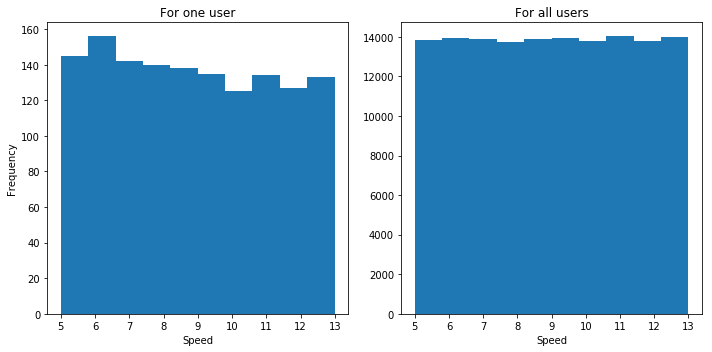

In [10]:
plot_event_average_speed()

In [11]:
def plot_event_average_position():
    fig, axes = plt.subplots(1, 2, figsize=(10,5))

    user_id = 0
    one_user = axes[0].hist2d(M_users[user_id][:,0], M_users[user_id][:,1], bins=(50,50), cmap=plt.cm.Greys)
    plt.colorbar(one_user[3], ax=axes[0])
    axes[0].set_ylabel('Y coordinate')
    axes[0].set_xlabel('X coordinate')
    axes[0].set_title('For one user')
        
    xs = []
    ys = []
    for i in range(N):
        xs.append(M_users[i][:,0])
        ys.append(M_users[i][:,1])
        
    all_users = axes[1].hist2d(np.concatenate(xs).ravel().tolist(), np.concatenate(ys).ravel().tolist(), bins=(50,50), cmap=plt.cm.Greys)
    plt.colorbar(all_users[3], ax=axes[1])
    axes[1].set_xlabel('X coordinate')
    axes[1].set_title('For all users')
    plt.tight_layout()
    plt.savefig('q3_event_average_position')
    plt.show()

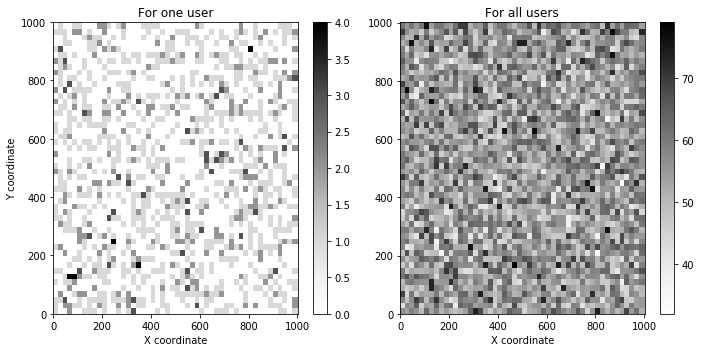

In [12]:
plot_event_average_position()

## Time Average Viewpoint

# Question 4

Code/Method setup 

In [477]:
def time_average_speed(intervals, user_times, user_v ) :
    sample_intervales = np.arange(0,86400,intervals)
    index_bins = np.digitize(sample_intervales, user_times)-1

    speed = [user_v[bins] for bins in index_bins]
    return np.mean(np.array(speed))

In [480]:
def CI_mean(data):
    n = len(data)
    mean = np.mean(data)
    std = calculate_std(data, mean) 
    U = mean + (1.96*std)/math.sqrt(n)
    L = mean - (1.96*std)/math.sqrt(n)
    
    return L,U

def CI_median(data):
    data_sort = np.sort(data)
    n = len(data)
    j = math.floor(0.5* n -  0.980 * math.sqrt(n)) -1
    k = math.ceil(0.5 * n+1 + 0.980 * math.sqrt(n)) - 1
    ##TODO check median indices
    return data_sort[j], data_sort[k]

def prediction_interval_normal(data):
    mean = np.mean(data)
    std = calculate_std(data, mean, False)
    
    L = mean - 1.96*std
    U = mean + 1.96*std 
    
    return L, U

def prediction_interval_order(data):  
    alpha = 1-0.95
    n = len(data)
    j = math.floor((n+1)*alpha/2)
    k = math.ceil((n+1)*(1-alpha/2))
    data_sorted = np.sort(data)
    
    #because in the thereom we start from 1.
    try:
        L,U = data_sorted[j-1], data_sorted[k-1]
    except:
        return None,None
        
    
    return L,U

In [481]:
def plot_intervals(data, x_label, y_label,interval_type): 
    mean   = np.mean(data)
    median = np.median(data) 
    L_mean, U_mean =  methods[interval_type][0](data)
    L_med, U_med  =   methods[interval_type][1](data)
    
    x0 = [0,0]
    y0_intervals = [L_mean,U_mean]
    y1_intervals = [L_med, U_med]
    
    title_mean = ''
    title_median = ''
    
    if(interval_type == "prediction"):
        print("Prediction interval normal [{},{}]".format(L_mean, U_mean))
        if(L_med != None):
            print("Prediction interval ordered statistics [{},{}]".format(L_med, U_med))
        
        title_mean = "prediction interval assuming the data are normal N="+str(len(data)) 
        title_median = "prediction interval using ordered statistics N=" + str(len(data))
        
    else :
        assert(interval_type=="confidence")
        print("Confidence interval of mean [{},{}]".format(L_mean, U_mean))
        print("Confidence interval of median [{},{}]".format(L_med, U_med))
        title_mean = "Confidence interval of mean N="+str(len(data))
        title_median = "Confidence interval of median N="+str(len(data))
        
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    fig.subplots_adjust(right=1.5,)
     
    axes[0].plot(x0, y0_intervals, marker = '_')
    axes[0].plot([0],[mean], marker='o') 
    axes[0].set_ylabel(y_label)
    axes[0].set_xlabel(x_label)
    axes[0].set_title(title_mean)
    
    
    
    if(L_med is not None) :
        axes[1].plot(x0, y1_intervals, marker = '_')
        axes[1].plot([0], [median], marker='o')
        axes[1].set_ylabel(y_label)
        axes[1].set_xlabel(x_label)
        axes[1].set_title(title_median)
    
    for ax in axes:
        ax.set_xticks([]) 

In [482]:
methods = {'confidence':(CI_mean, CI_median) , 'prediction': (prediction_interval_normal, prediction_interval_order)}

In [498]:
interval = 10
T_V = list(zip(T_users, V_users))
Y_N = np.array([time_average_speed(interval,user_times, user_v) for (user_times, user_v) in  T_V])
X_N = np.array([np.mean(v_user) for v_user in V_users ])

### a)

Assumptions we use the theorem 2.2 due to us not knowing the data coming from a normal distribution
We estimate the confidence interval of the mean.

Confidence intervals for X at level 0.95
Confidence interval of mean [8.991443063103867,9.014971273381972]
Confidence interval of median [8.989295584159136,9.026168716279825]


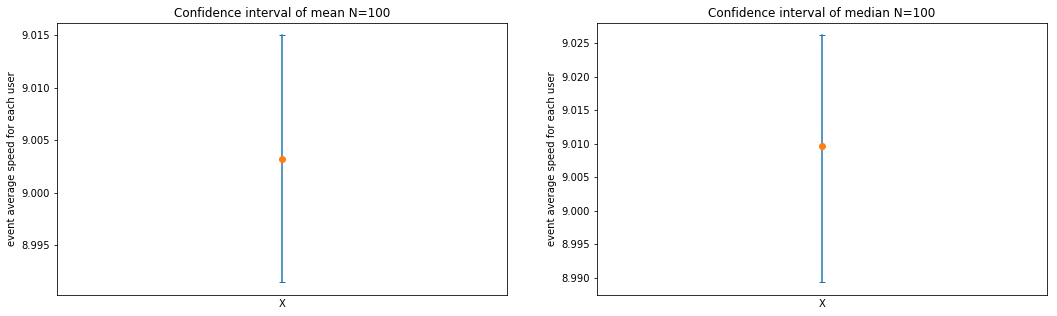

In [499]:
print("Confidence intervals for X at level 0.95")
plot_intervals(X_N,"X", "event average speed for each user", "confidence")

Confidence intervals for Y at level 0.95
Confidence interval of mean [8.368885730359091,8.398384254956175]
Confidence interval of median [8.365892493736318,8.402322439606591]


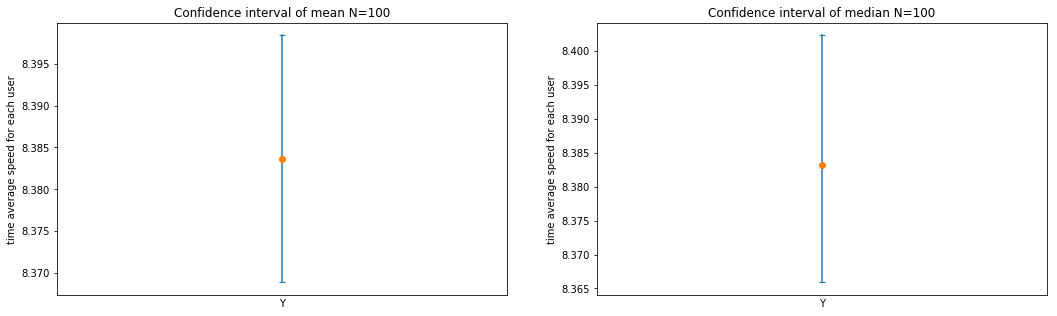

In [500]:
print("Confidence intervals for Y at level 0.95")
plot_intervals(Y_N, "Y","time average speed for each user", "confidence")

###  b) (Todo)

###  c)

Confidence intervals for X at level 0.95
Confidence interval of mean [8.964017264757233,9.016366830685607]
Confidence interval of median [8.95147892255317,9.035154522246197]


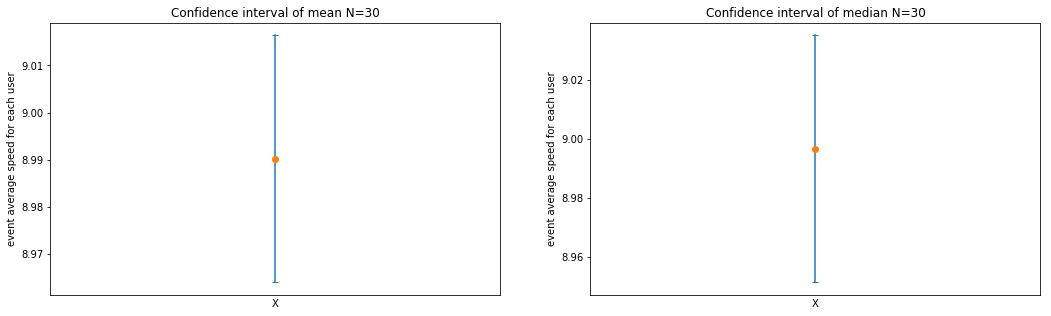

In [501]:
print("Confidence intervals for X at level 0.95")
plot_intervals(X_N[:30], "X","event average speed for each user", "confidence")

Confidence intervals for Y at level 0.95
Confidence interval of mean [8.338279190964464,8.403839134655183]
Confidence interval of median [8.31077728386606,8.433218258506603]


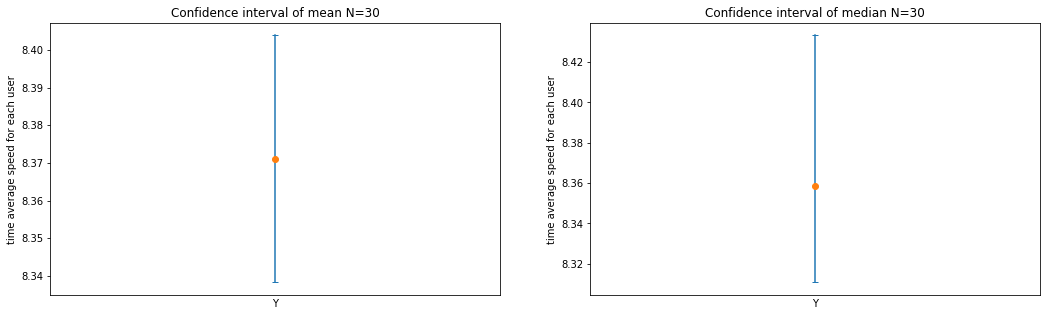

In [502]:
print("Confidence intervals for Y at level 0.95")
plot_intervals(Y_N[:30], "Y","time average speed for each user", "confidence")

### d) (Todo)

## Exercise 4.2

Prediction Interval based on Mean

### a) and b) plots

N =100

Prediction interval normal [8.23539932908551,8.531870656229756]
Prediction interval ordered statistics [8.221929890546786,8.526956819290184]


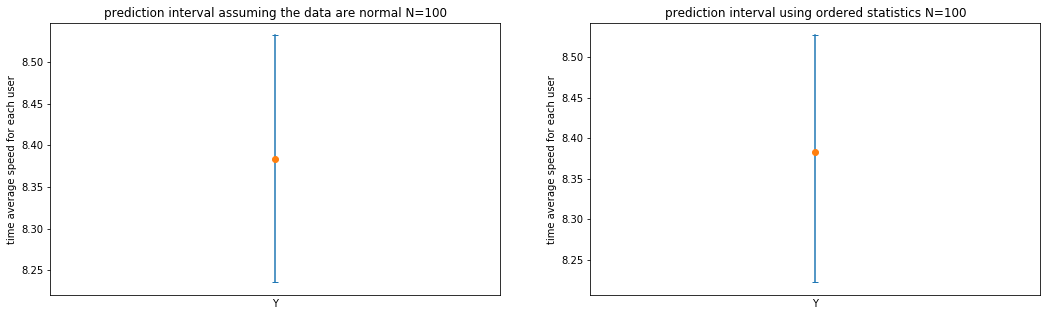

In [503]:
plot_intervals(Y_N, "Y", "time average speed for each user", "prediction")

N = 60

Prediction interval normal [8.230014706770717,8.539739894215295]
Prediction interval ordered statistics [8.221929890546786,8.610625185500414]


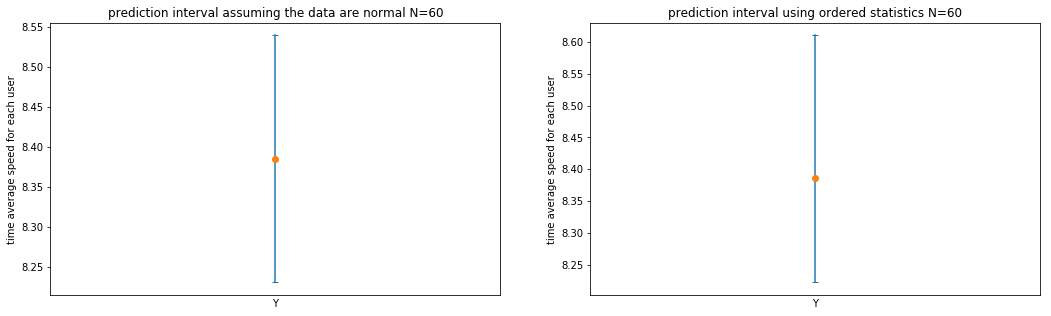

In [504]:
plot_intervals(Y_N[:60], "Y", "time average speed for each user", "prediction")

N = 30

As seen in theorem 2.5 there is no prediction interval at level 95% with this method. But however using theorem 2.6 which is based on the mean. There exists a prediction interval which we plot and display

Prediction interval normal [8.188446524092077,8.55367180152757]


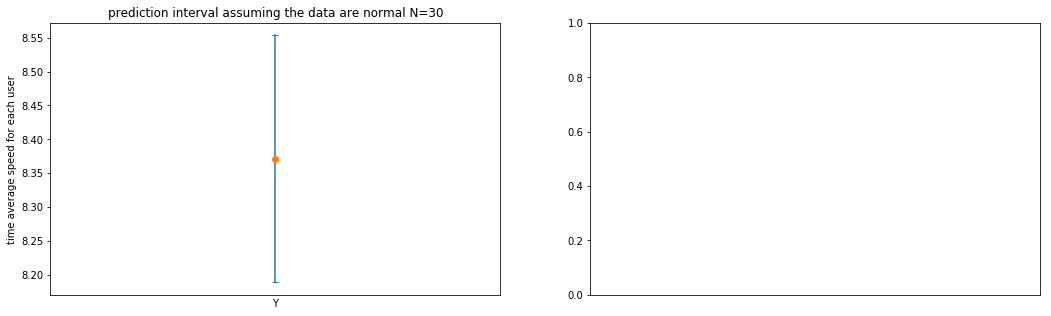

In [505]:
plot_intervals(Y_N[:30], "Y", "time average speed for each user", "prediction")

### c) (Todo)

### d) (Todo)